In [68]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC  # Import SVM
import numpy as np
import os
from google.colab import drive
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed, Flatten

In [69]:
#Globals
num_features = 595
num_classes = 4 # no punch, straight, hook, uppercut
NUM_FEATURES_PER_SEQUENCE = 98

In [70]:
#Loading data
NUM_FEATURES_PER_SEQUENCE = 98

drive.mount('/content/drive')
folderPath = "/content/drive/MyDrive/229 ._./Labeled/" #change as appropriate
file_list = [f for f in os.listdir(folderPath)]
Xs = []
Ys = []

dtype = [('column1', 'U10')] + [('column{}'.format(i), float) for i in range(2, num_features + 1)]

for file in file_list:
  temp = np.genfromtxt(f"{folderPath}{file}", delimiter=',', dtype=dtype)
  data = np.array([list(row) for row in temp])
  Xs.append(np.array([row[7:].astype(float) for row in data]))
  Ys.append(np.array([row[6].astype(float).astype(int) for row in data]))


X_nonorm = np.vstack(Xs)
mean = np.mean(X_nonorm, axis=0)
std_dev = np.std(X_nonorm, axis=0)
normalized_data = (X_nonorm - mean) / std_dev
Y = np.hstack(Ys)
X = normalized_data

numSamples = len(X_nonorm)
normalized_data = np.reshape(normalized_data, (numSamples, 6, NUM_FEATURES_PER_SEQUENCE))
X_nonorm = np.reshape(X_nonorm, (numSamples, 6, NUM_FEATURES_PER_SEQUENCE))

X = normalized_data

for i in range(35,98,2):
  X[:, :, i] = X_nonorm[:, :, i]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
# 90 10 train test
from sklearn.model_selection import StratifiedShuffleSplit

sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in sss_train_test.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

In [123]:
# Build LSTM Model
input_layer = Input(shape=(6, NUM_FEATURES_PER_SEQUENCE))
lstm_layer1 = Bidirectional(LSTM(units=448, return_sequences=True))(input_layer) # best units so far: 448 -> 256
lstm_layer2 = Bidirectional(LSTM(units=256))(lstm_layer1)
feature_extractor = Model(inputs=input_layer, outputs=lstm_layer2)

In [124]:
# Extract Features from LSTM Layers
X_train_lstm_features = feature_extractor.predict(X_train)
X_test_lstm_features = feature_extractor.predict(X_test)

92/92 [==============================] - 6s 65ms/step


In [125]:
# Build SVM model
svm_model = SVC(kernel='rbf', class_weight='balanced', verbose=True, decision_function_shape='ovo')

In [126]:
# Train SVM model
svm_model.fit(X_train_lstm_features, y_train)

[LibSVM]

SVC(class_weight='balanced', decision_function_shape='ovo', verbose=True)

In [127]:
# Evaluate SVM model
y_pred = svm_model.predict(X_test_lstm_features)

balanced_acc = balanced_accuracy_score(y_test, y_pred)
accuracy = svm_model.score(X_test_lstm_features, y_test)
print(f'Accuracy: {accuracy}, Balanced Accuracy: {balanced_acc}')
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy: 0.720164609053498, Balanced Accuracy: 0.5439742844183459
Confusion Matrix:
[[1920  272  202  169]
 [  31  110   44    9]
 [  15   25   56   29]
 [   7    6    7   14]]


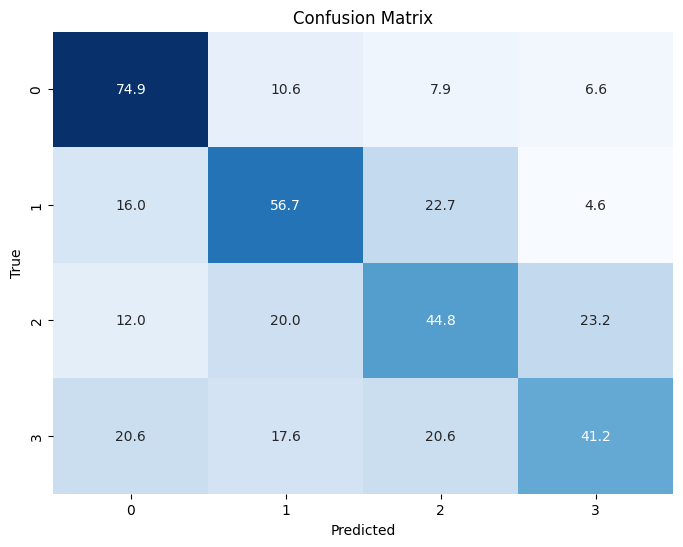

In [128]:
import seaborn as sns

cmr = cm / cm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(cmr, annot=True, cmap='Blues', fmt='.1f', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('cm3.png')
plt.show()

In [110]:
import joblib
from tensorflow.keras.models import save_model

# Save SVM model
joblib.dump(svm_model, 'svm_model.pkl')

# Save LSTM model
feature_extractor.save('lstm_feature_extraction.keras')